In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [2]:
with zipfile.ZipFile("../data/application_train.csv.zip","r") as zip_ref:
    zip_ref.extractall(os.getcwd())

In [3]:
train_data = pd.read_csv('application_train.csv',index_col='SK_ID_CURR')
print('The size of train_data is:',train_data.shape)

The size of train_data is: (307511, 121)


In [4]:
os.remove("application_train.csv")

In [43]:
# Creating new dataframe with columns = category_cols
category_cols = [col for col in list(train_data) if train_data[col].dtype == 'object']
df = pd.DataFrame(columns=category_cols)

In [44]:
encoder = OrdinalEncoder()
for col in category_cols:
    df[col] = train_data[col]
    t = np.array(df[df[col].notna()==True][col])
    impute_reshape = t.reshape(-1,1)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    df.loc[df[df[col].notnull()==True].index,col] = np.squeeze(impute_ordinal)

In [45]:
# Merging train_data with df with category columns on train_data dropped first. Index resetted for merging dataframes
train_data = train_data.drop(labels = category_cols,axis=1).reset_index()
df = df.reset_index()
train_data = pd.merge(train_data, df, on='SK_ID_CURR')
train_data.set_index('SK_ID_CURR',inplace=True)

In [46]:
# Call ordinalencoder
encoder = OrdinalEncoder()

# Creating a list which contain category columns
category_cols = [col for col in list(train_data) if train_data[col].dtype == 'object']

# Creating new dataframe with columns = category_cols
df = pd.DataFrame(columns=category_cols)

# Loop to each col in category_cols 
for col in category_cols:
    df[col] = train_data[col]
    t = np.array(df[df[col].notna()==True][col])
    impute_reshape = t.reshape(-1,1)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    df.loc[df[df[col].notnull()==True].index,col] = np.squeeze(impute_ordinal)

# Merging train_data with df with category columns on train_data dropped first. Index resetted for merging dataframes
train_data = train_data.drop(labels = category_cols,axis=1).reset_index()
df = df.reset_index()

# Merge df with train_data
train_data = pd.merge(train_data, df, on='SK_ID_CURR')
train_data.set_index('SK_ID_CURR',inplace=True)

In [47]:
# List all columns that consist of discrete numbers 
flag_columns = [col for col in list(train_data) if 'FLAG_' in col]
reg_columns = [col for col in list(train_data) if '_REGION' in col]
city_columns = [col for col in list(train_data) if '_CITY' in col]
amt_columns = [col for col in list(train_data) if 'AMT_' in col]
reg_rating_columns = [col for col in list(train_data) if 'REGION_RATING' in col]
soc_circle_columns = [col for col in list(train_data) if 'SOCIAL_CIRCLE' in col]
days_columns = [col for col in list(train_data) if 'DAYS_' in col]
other_disc_columns = ['CNT_CHILDREN','OWN_CAR_AGE','CNT_CHILDREN','CNT_FAM_MEMBERS','HOUR_APPR_PROCESS_START']
all_discrete_columns = category_cols + flag_columns + reg_columns + city_columns + amt_columns + reg_rating_columns + soc_circle_columns + days_columns + other_disc_columns

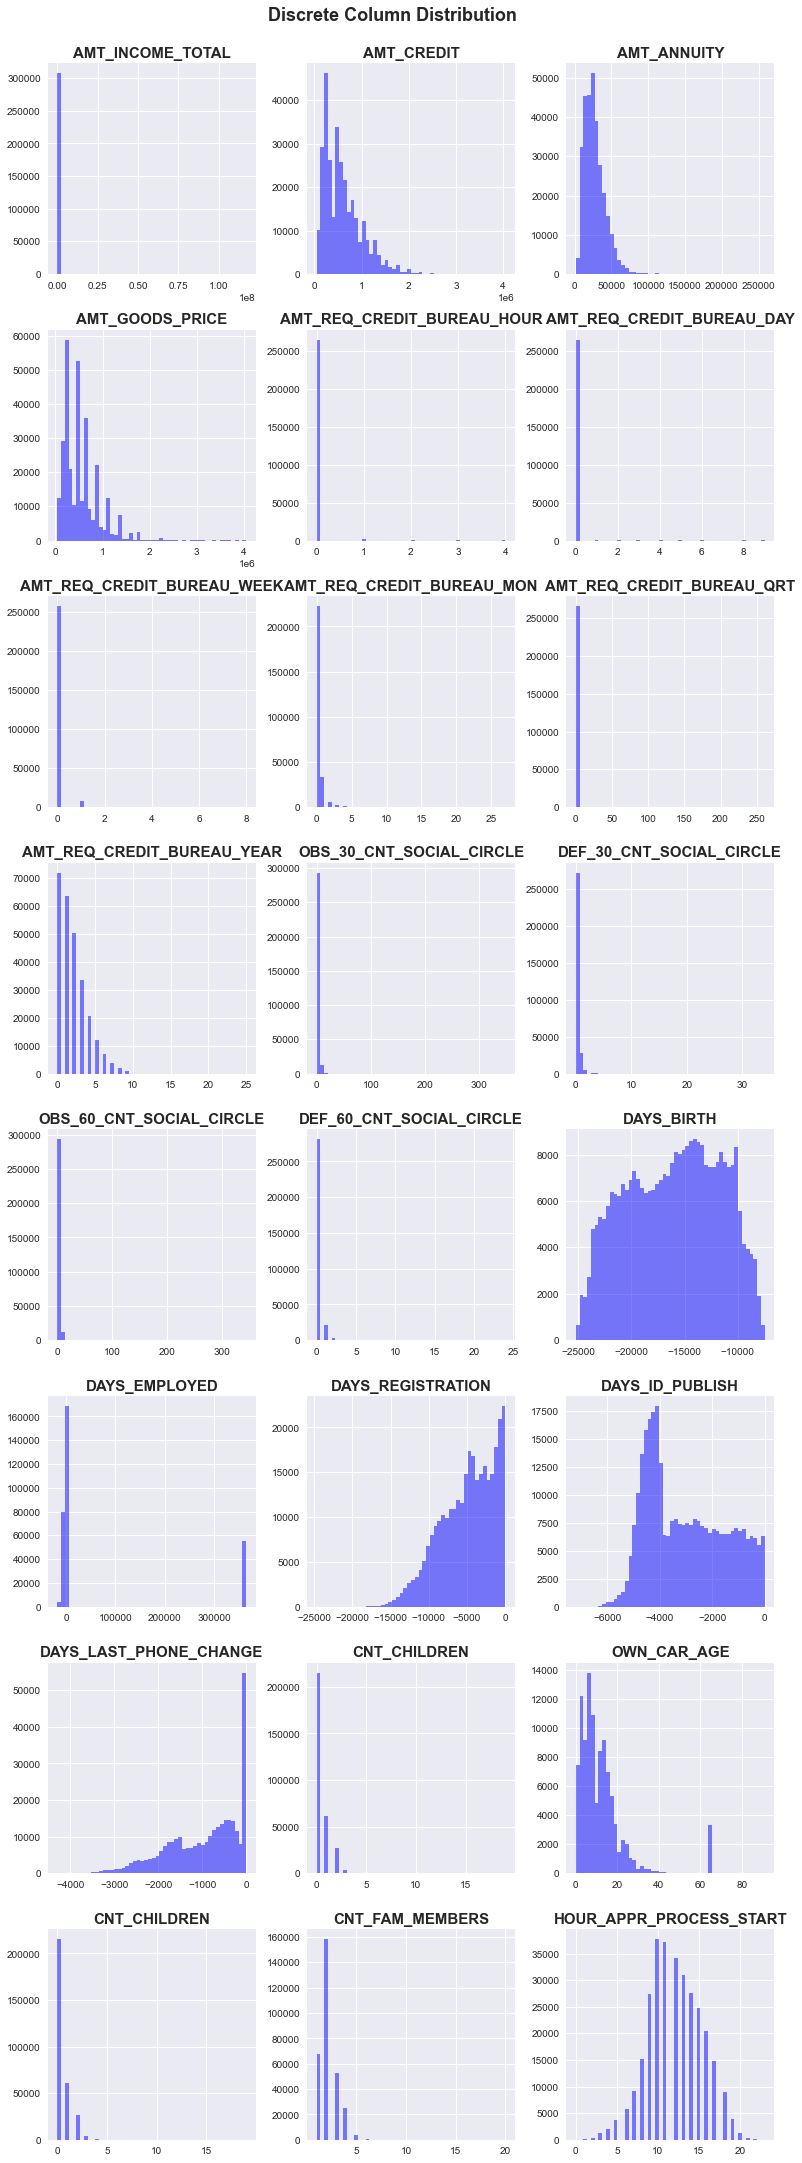

In [48]:
%matplotlib inline
#Plotting distribution of cnt columns
plt.style.use('seaborn')

#Column to plot (except flag-type columns and rating columns)
cols_list = amt_columns+soc_circle_columns+days_columns+other_disc_columns

fig, ax = plt.subplots(nrows=8, ncols=3)

for i in range(0,8):
    for j in range(0,3):
        ax[i,j].hist(train_data[cols_list[3*i+j]],bins=50,color='b',alpha=0.5)
        ax[i,j].set_title(cols_list[3*i+j], fontweight='bold',fontsize=15)
    
fig.suptitle('Discrete Column Distribution', fontsize=18, y=1, fontweight='bold', x=0.5)
fig.set_figheight(30)
fig.set_figwidth(11)
fig.tight_layout()
plt.show()

In [49]:
# Drop data for AMT_INCOME_TOTAL > 100000000
train_data['AMT_INCOME_TOTAL'] = train_data['AMT_INCOME_TOTAL'].apply(lambda x: np.nan if x > 100000000 else x)

# Drop data for DAYS_EMPLOYED < 0
train_data['DAYS_EMPLOYED'] = train_data['DAYS_EMPLOYED'].apply(lambda x: np.nan if x < 0 else x)

### Imputing Missing Values

In [50]:
# Defining imputation by MICE method function
def impute_MICE(df):
    df_columns = df.columns
    imp_mean = IterativeImputer(initial_strategy = "mean", n_nearest_features = 15, random_state = 0, imputation_order="ascending")
    x = imp_mean.fit(df)
    X = df
    df_MICE_imputed = pd.DataFrame(imp_mean.transform(X),index=df.index)
    df_MICE_imputed.columns = df_columns
    return df_MICE_imputed

In [51]:
#Change data type to float for imputation preparation
for col in list(train_data):
    if train_data[col].dtype == 'object':
        train_data[col] = train_data[col].astype(float)

# Exclude 'TARGET' from train_data to prevent data leakage
imputation_data = train_data.drop('TARGET',axis=1)

# Imputing train data, (mice function only accept np.array data) and format it to dataframe
imputing_train = impute_MICE(imputation_data)
imputed_train = pd.DataFrame(imputing_train, columns=imputation_data.columns)

D:\Analytics\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [54]:
# Rounding numbers in columns that are discrete
imputed_train[all_discrete_columns] = np.round(imputed_train[all_discrete_columns])

# Concat with TARGET to get final imputed_train
final_imputed_train = pd.merge(left=imputed_train.reset_index(), right=train_data['TARGET'].reset_index(), on='SK_ID_CURR')
final_imputed_train = final_imputed_train.set_index('SK_ID_CURR')

display(final_imputed_train.head())

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,202500.0,406598.0,24700.0,351000.0,0.018801,-9461.0,-51786.0,-3648.0,-2120.0,...,3.0,1.0,8.0,6.0,5.0,2.0,0.0,5.0,0.0,1
100003,0.0,270000.0,1293502.0,35698.0,1129500.0,0.003541,-16765.0,221517.0,-1186.0,-291.0,...,1.0,1.0,3.0,1.0,39.0,2.0,0.0,0.0,0.0,0
100004,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-3679.0,-4260.0,-2531.0,...,3.0,1.0,8.0,1.0,11.0,2.0,0.0,4.0,0.0,0
100006,0.0,135000.0,312682.0,29686.0,297000.0,0.008019,-19005.0,-51820.0,-9833.0,-2437.0,...,0.0,1.0,8.0,6.0,5.0,2.0,0.0,4.0,0.0,0
100007,0.0,121500.0,513000.0,21866.0,513000.0,0.028663,-19932.0,205463.0,-4311.0,-3458.0,...,3.0,1.0,3.0,4.0,37.0,2.0,0.0,4.0,0.0,0


In [55]:
final_imputed_train.isna().sum()

CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
AMT_CREDIT             0
AMT_ANNUITY            0
AMT_GOODS_PRICE        0
                      ..
FONDKAPREMONT_MODE     0
HOUSETYPE_MODE         0
WALLSMATERIAL_MODE     0
EMERGENCYSTATE_MODE    0
TARGET                 0
Length: 121, dtype: int64

## Using Regularization to select the most important variables

In [60]:
# Declare X and y for regularization process
X = final_imputed_train.drop('TARGET',axis=1)
y = final_imputed_train['TARGET']
clf = Lasso(alpha=0.005,max_iter=10000)
scaler = StandardScaler()
clf.fit(scaler.fit_transform(X), y)

# Create a list of final_features that will be used
final_features = []
for i in range(len(list(X))):
    if clf.coef_[i]:
        final_features.append(list(X)[i])

print('There are',len(final_features),'features that will be used, they are: ', final_features)

There are 10 features that will be used, they are:  ['REG_CITY_NOT_LIVE_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_3', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE']


In [61]:
# Create dataframe consist of features and their importances
feature_importance = pd.DataFrame(data = np.abs(clf.coef_),index=list(X),columns=['Importance'])
feature_importance = feature_importance[feature_importance['Importance'] != 0].sort_values(by='Importance',ascending=False)
feature_importance.head()

,Importance
EXT_SOURCE_3,0.032780
EXT_SOURCE_2,0.030516
EXT_SOURCE_1,0.019114
NAME_EDUCATION_TYPE,0.004937
FLAG_OWN_CAR,0.002635


In [63]:
# Updating train data set with only final features and save it to csv
final_train = pd.concat([X[final_features],y],axis=1)
final_train.to_csv('../data/final_train.csv',index='SK_ID_CURR')